### Gerekli Kütüphaneler

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import seaborn as sns
from networkx.algorithms import community
from pyvis.network import Network
import time
import random
import pandas as pd
from matplotlib import cm

### Veri Yükleme

In [29]:
file_path = 'web-Google.txt'

G = nx.DiGraph()

with open(file_path, 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        src, dst = map(int, line.strip().split())
        G.add_edge(src, dst)

### Grafı örnekleme

- web-Google ağı çok büyük olduğundan üzerinde çalışabilmek adında küçültme optimizasyonu

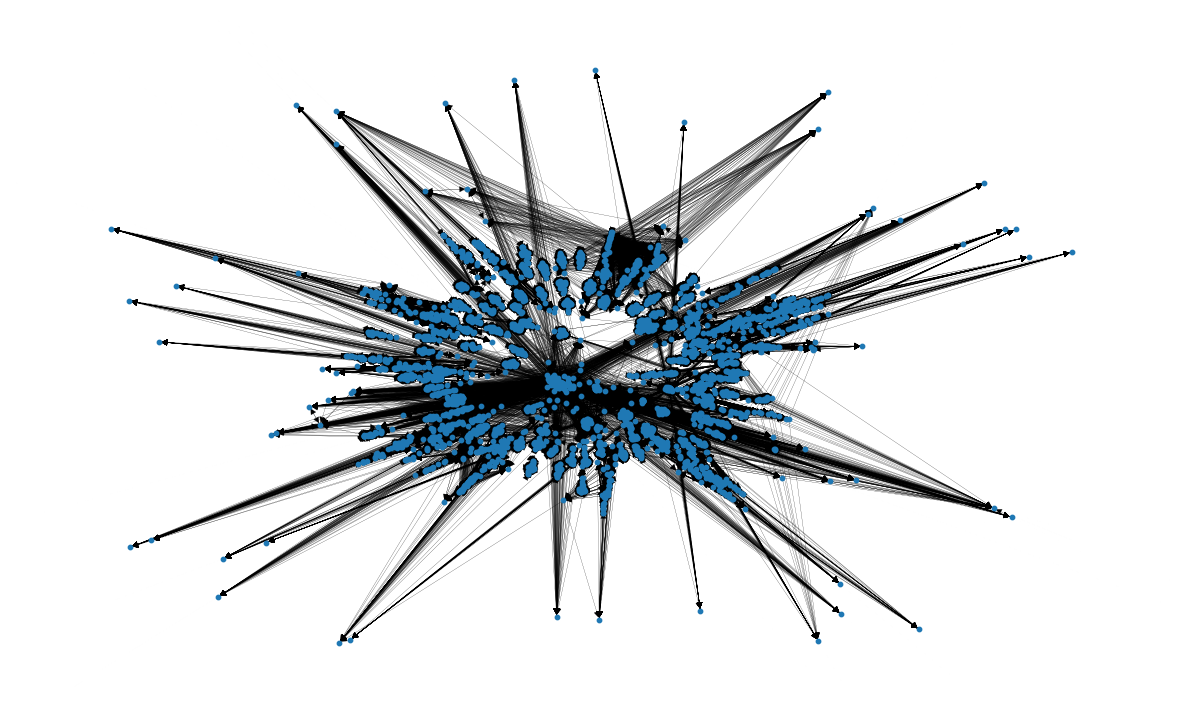

In [30]:
k = 35
k_core = nx.k_core(G, k)
G = k_core.copy()

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

# top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10000]
#
# top_10000_nodes = [node for node, degree in top_nodes]
#
# G = G.subgraph(top_10000_nodes).copy()

### Grafın Görselleştirilmesi

In [10]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:1200]
H = G.subgraph([node for node, _ in top_nodes]).copy()

net = Network(notebook=True, cdn_resources='in_line', directed=True)
net.from_nx(H)

net.toggle_physics(False)

net.set_options("""
var options = {
  "physics": {
    "enabled": true,
    "solver": "forceAtlas2Based",
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "springLength": 100,
      "springConstant": 0.08
    },
    "minVelocity": 0.75,
    "stabilization": {
      "enabled": true,
      "iterations": 1000
    }
  }
}
""")

print("Ağda en yüksek dereceli örnek grubunun görselleştirilmesi")
net.show("google_web_graph.html")

Ağda en yüksek dereceli örnek grubunun görselleştirilmesi
google_web_graph.html


## Temel İstatistikler

### Düğüm ve Kenar Sayısı

In [11]:
print(f"Düğüm Sayısı: {G.number_of_nodes()}")
print(f"Kenar Sayısı: {G.number_of_edges()}")

Düğüm Sayısı: 3287
Kenar Sayısı: 66600


### İç ve dış derece

In [12]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
degree = dict(G.degree)

print(f"Ortalama Derece: {np.mean(list(degree.values())):.2f}")
print(f"Ortalama İç Derece: {np.mean(list(in_degrees.values())):.2f}")
print(f"Ortalama Dış Derece: {np.mean(list(out_degrees.values())):.2f}")

Ortalama Derece: 40.52
Ortalama İç Derece: 20.26
Ortalama Dış Derece: 20.26


### Ağ Yoğunluğu

In [13]:
print(f"Ağ Yoğunluğu: {nx.density(G):.8f}")

Ağ Yoğunluğu: 0.00616605


### Bağlantı güçleri

In [14]:
strong_components = list(nx.strongly_connected_components(G))
weak_components = list(nx.weakly_connected_components(G))

print(f"Strongly Connected Components sayısı: {len(strong_components)}")
print(f"Weakly Connected Components sayısı: {len(weak_components)}")

largest_strong = max(strong_components, key=len)
largest_weak = max(weak_components, key=len)

print(f"En büyük Strongly Connected Component boyutu: {len(largest_strong)}")
print(f"En büyük Weakly Connected Component boyutu: {len(largest_weak)}")

Strongly Connected Components sayısı: 297
Weakly Connected Components sayısı: 93
En büyük Strongly Connected Component boyutu: 76
En büyük Weakly Connected Component boyutu: 1141


### Derece Dağılım Analizi

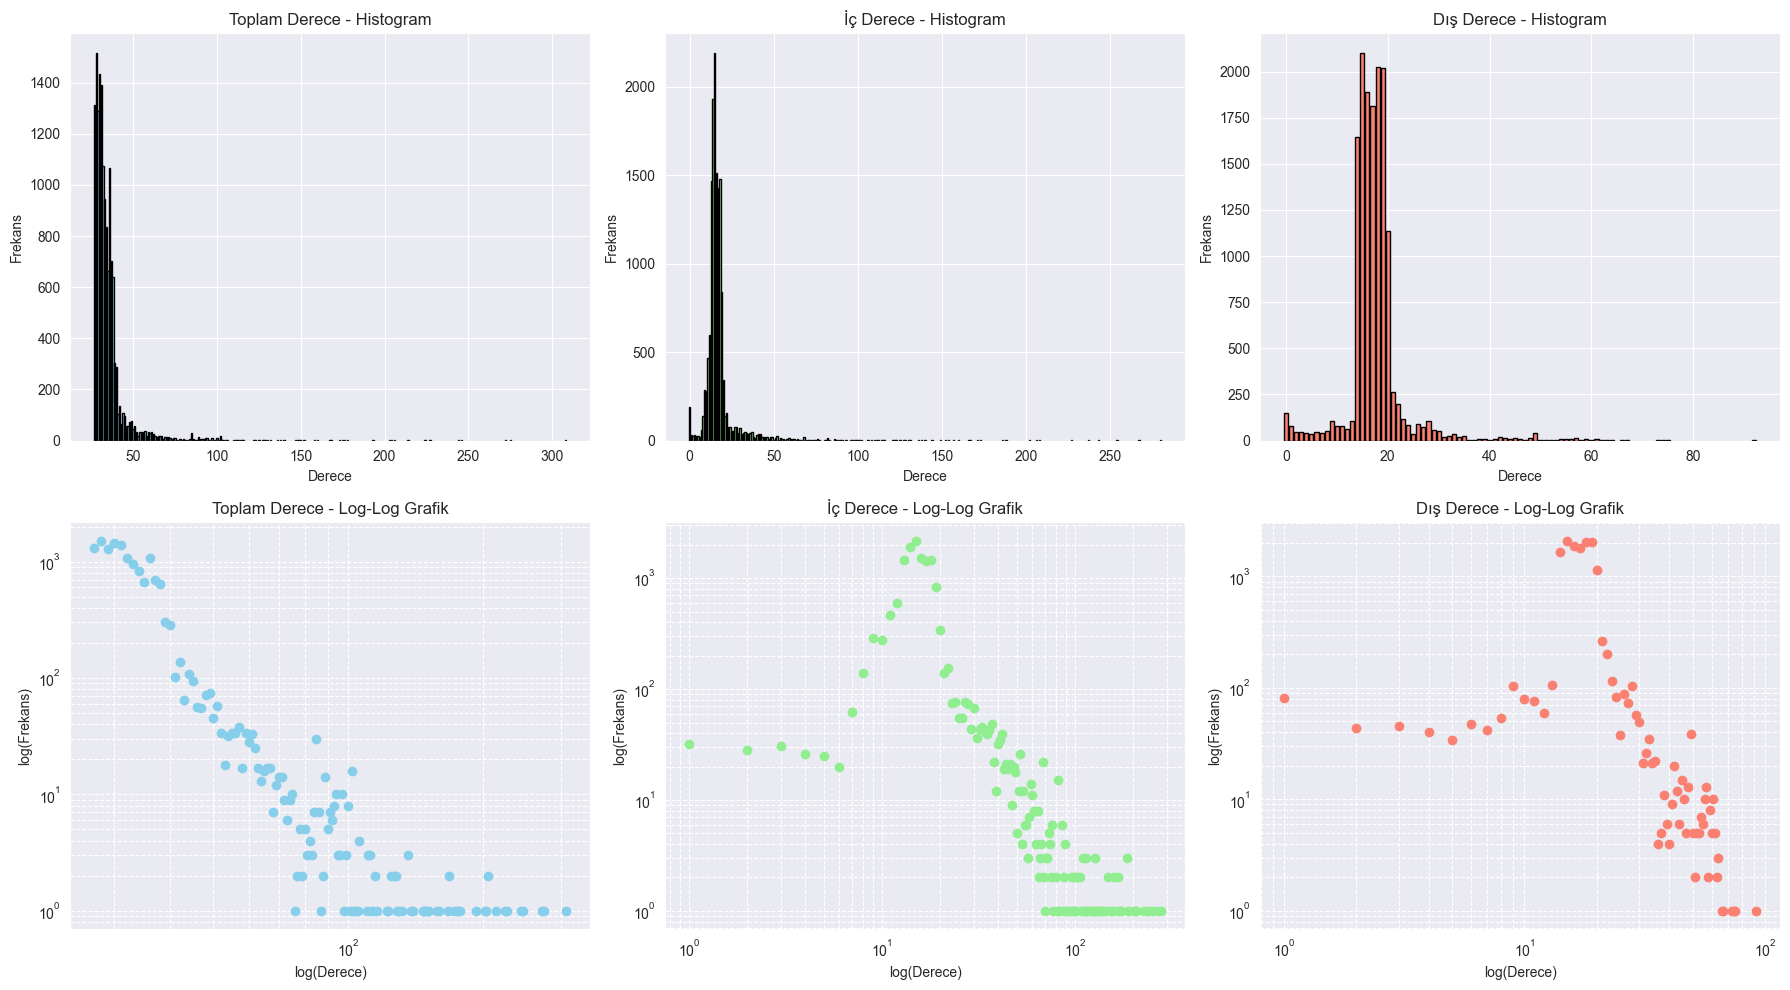

In [112]:
toplam_derece_listesi = [d for n, d in G.degree()]
ic_derece_listesi = [d for n, d in G.in_degree()]
dis_derece_listesi = [d for n, d in G.out_degree()]

# Hepsini bir arada işle
dereceler = [
    ("Toplam Derece", toplam_derece_listesi, 'skyblue'),
    ("İç Derece", ic_derece_listesi, 'lightgreen'),
    ("Dış Derece", dis_derece_listesi, 'salmon')
]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 satır 3 sütun

for i, (baslik, derece_listesi, renk) in enumerate(dereceler):
    # Derece frekanslarını hesapla
    derece_sayimi = collections.Counter(derece_listesi)
    derece, frekans = zip(*sorted(derece_sayimi.items()))

    # Histogram (doğrusal)
    axs[0, i].bar(derece, frekans, width=0.8, color=renk, edgecolor='black')
    axs[0, i].set_title(f"{baslik} - Histogram")
    axs[0, i].set_xlabel("Derece")
    axs[0, i].set_ylabel("Frekans")
    axs[0, i].grid(True)

    # Log-Log Grafik
    axs[1, i].loglog(derece, frekans, marker='o', linestyle='None', color=renk)
    axs[1, i].set_title(f"{baslik} - Log-Log Grafik")
    axs[1, i].set_xlabel("log(Derece)")
    axs[1, i].set_ylabel("log(Frekans)")
    axs[1, i].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

### Çap

In [113]:
if nx.is_strongly_connected(G):
    print("Çap:", nx.diameter(G))
else:
    print("Graf strongly connected değil, çap sonsuz olabilir.")
    # Alternatif: Her bileşen için çap hesapla
    components = nx.strongly_connected_components(G)
    max_diameter = 0
    for component in components:
        subgraph = G.subgraph(component)
        if len(subgraph) > 1:
            d = nx.diameter(subgraph)
            max_diameter = max(max_diameter, d)
    print("En büyük strongly connected component çapı:", max_diameter)

Graf strongly connected değil, çap sonsuz olabilir.
En büyük strongly connected component çapı: 14


## Merkezilik Ölçümleri

Merkezilik ölçümleri, ağdaki düğümlerin önemini farklı açılardan değerlendirir:
- **Derece Merkeziliği**: Bir düğümün bağlantı sayısına dayalı önemi
- **Yakınlık Merkeziliği**: Bir düğümün ağdaki diğer düğümlere ne kadar yakın olduğunu ölçer
- **Arasındalık Merkeziliği**: Bir düğümün, diğer düğümler arasındaki en kısa yollar üzerinde ne kadar bulunduğunu gösterir

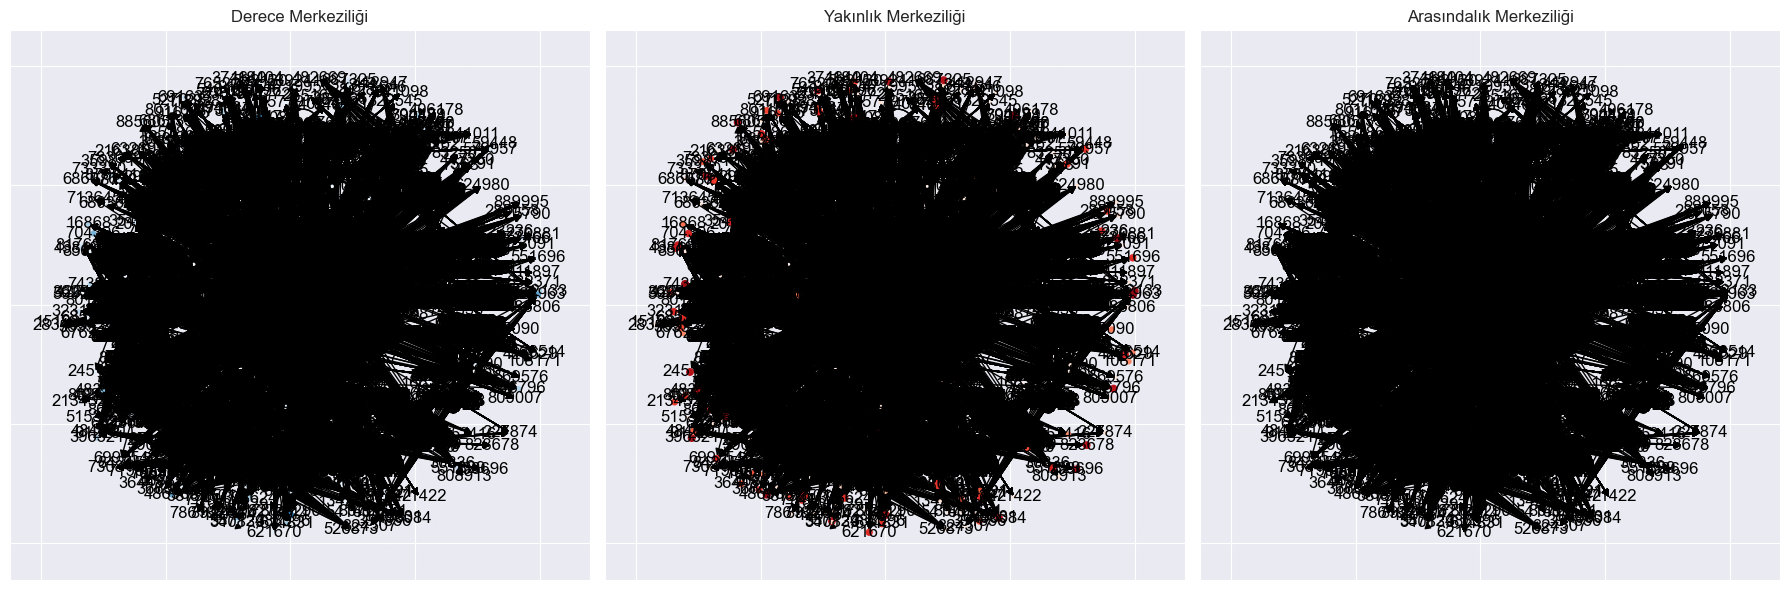

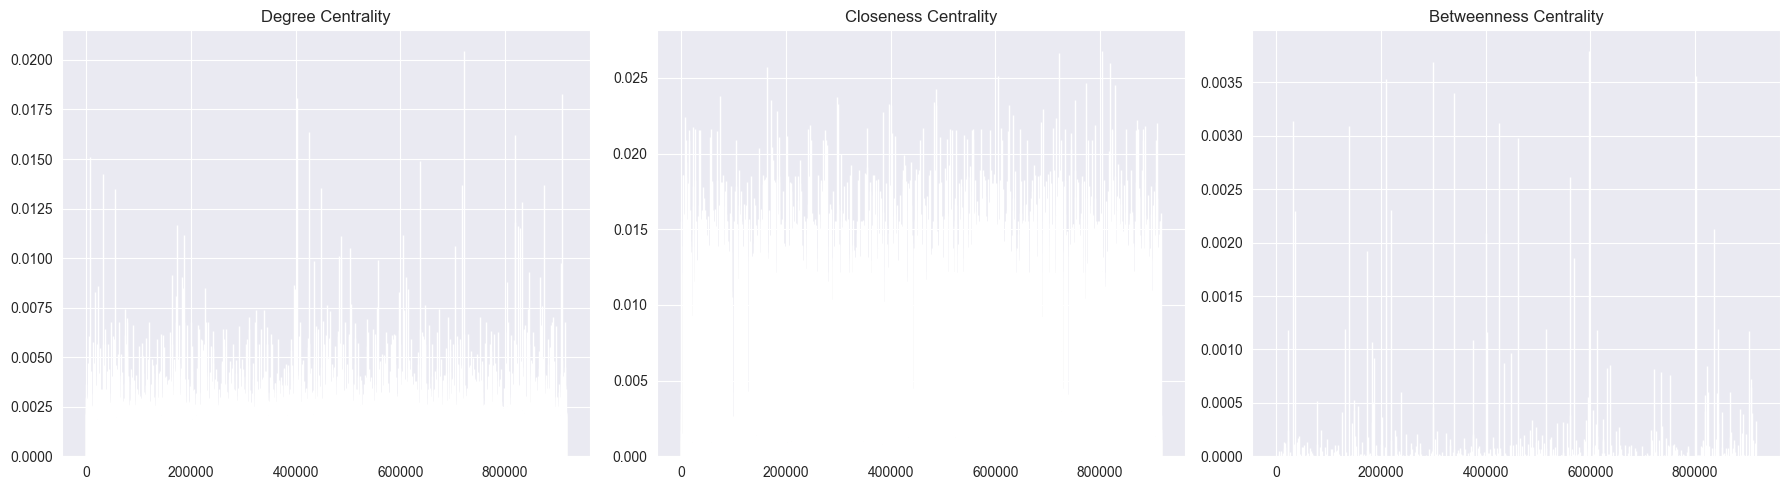

In [114]:
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

pos = nx.spring_layout(G, seed=42)

axs[0].set_title('Derece Merkeziliği')
nx.draw_networkx(G, pos=pos, ax=axs[0], node_size=[v * 1000 for v in degree.values()],
                 node_color=list(degree.values()), cmap=plt.cm.Blues)

axs[1].set_title('Yakınlık Merkeziliği')
nx.draw_networkx(G, pos=pos, ax=axs[1], node_size=[v * 1000 for v in closeness.values()],
                 node_color=list(closeness.values()), cmap=plt.cm.Reds)

axs[2].set_title('Arasındalık Merkeziliği')
nx.draw_networkx(G, pos=pos, ax=axs[2], node_size=[v * 1000 for v in betweenness.values()],
                 node_color=list(betweenness.values()), cmap=plt.cm.Greens)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(degree.keys(), degree.values(), color='skyblue')
axs[0].set_title("Degree Centrality")

axs[1].bar(closeness.keys(), closeness.values(), color='lightgreen')
axs[1].set_title("Closeness Centrality")

axs[2].bar(betweenness.keys(), betweenness.values(), color='salmon')
axs[2].set_title("Betweenness Centrality")

plt.tight_layout()
plt.show()

### Kümelenme Katsayısı (Clustering Coefficient)

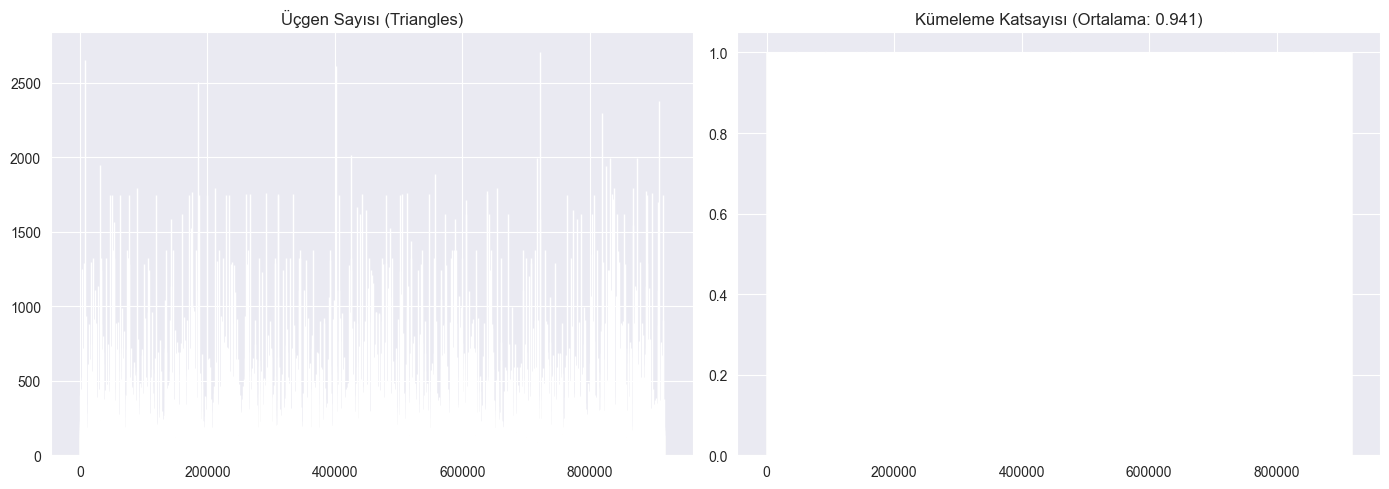

In [115]:
# Eğer G yönlü ise bunu ekle:
G_undir = G.to_undirected()

triangles = nx.triangles(G_undir)
clustering = nx.clustering(G_undir)
avg_clustering = nx.average_clustering(G_undir)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(triangles.keys(), triangles.values(), color='orange')
axs[0].set_title("Üçgen Sayısı (Triangles)")

axs[1].bar(clustering.keys(), clustering.values(), color='purple')
axs[1].set_title(f"Kümeleme Katsayısı (Ortalama: {avg_clustering:.3f})")

plt.tight_layout()
plt.show()

### PageRank Analizi

PageRank hesaplaması başlatılıyor...
PageRank hesaplaması tamamlandı.
PageRank hesaplama süresi: 0.04 saniye

En Yüksek PageRank Skoruna Sahip İlk 15 Düğüm:
1. Düğüm: 568687, PageRank Skoru: 0.00772385
2. Düğüm: 76969, PageRank Skoru: 0.00266004
3. Düğüm: 8329, PageRank Skoru: 0.00228269
4. Düğüm: 108690, PageRank Skoru: 0.00227803
5. Düğüm: 342267, PageRank Skoru: 0.00226873
6. Düğüm: 185067, PageRank Skoru: 0.00205315
7. Düğüm: 841575, PageRank Skoru: 0.00199329
8. Düğüm: 908351, PageRank Skoru: 0.00182277
9. Düğüm: 737459, PageRank Skoru: 0.00162007
10. Düğüm: 557124, PageRank Skoru: 0.00147233
11. Düğüm: 721816, PageRank Skoru: 0.00144074
12. Düğüm: 185821, PageRank Skoru: 0.00121117
13. Düğüm: 371811, PageRank Skoru: 0.00116683
14. Düğüm: 241990, PageRank Skoru: 0.00114792
15. Düğüm: 309990, PageRank Skoru: 0.00114098


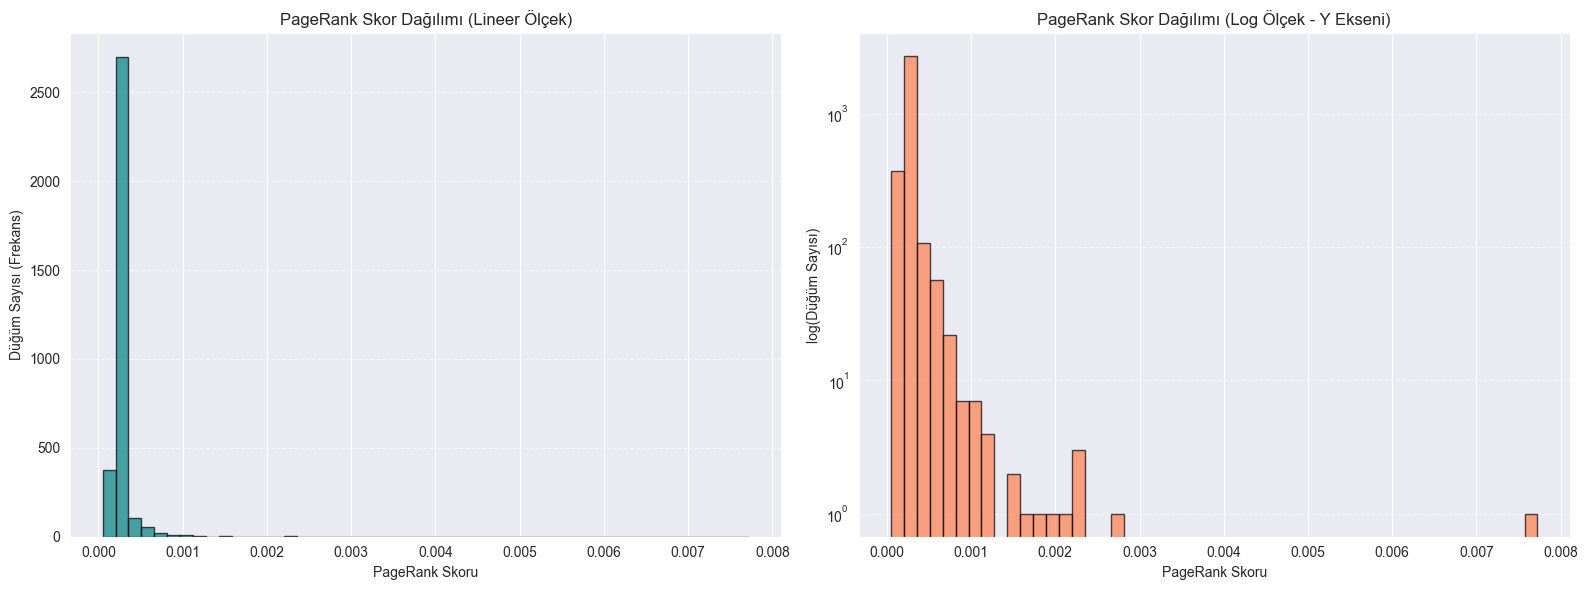


En yüksek PageRank skoruna sahip 1000 düğümden oluşan alt graf görselleştiriliyor...


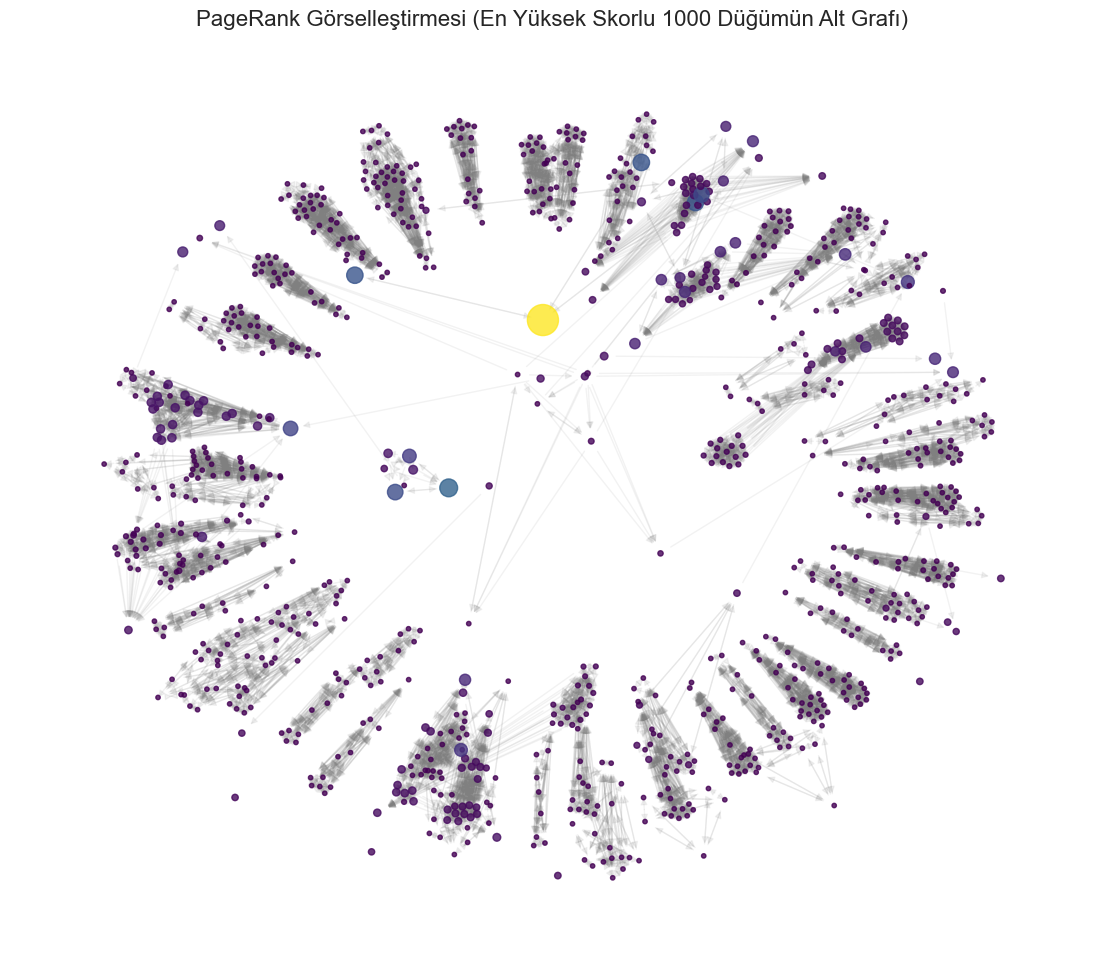

In [27]:
pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1.0e-6)

num_top_nodes_pr = 15
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda item: item[1], reverse=True)

print(f"\nEn Yüksek PageRank Skoruna Sahip İlk {num_top_nodes_pr} Düğüm:")
for i, (node, score) in enumerate(sorted_pagerank[:num_top_nodes_pr]):
    print(f"{i+1}. Düğüm: {node}, PageRank Skoru: {score:.8f}")

pagerank_values = list(pagerank_scores.values())

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(pagerank_values, bins=50, color='teal', alpha=0.7, edgecolor='black')
axs[0].set_title('PageRank Skor Dağılımı (Lineer Ölçek)')
axs[0].set_xlabel('PageRank Skoru')
axs[0].set_ylabel('Düğüm Sayısı (Frekans)')
axs[0].grid(True, axis='y', linestyle='--', alpha=0.6)

non_zero_pagerank_values = [score for score in pagerank_values if score > 0]
if non_zero_pagerank_values:
     axs[1].hist(non_zero_pagerank_values, bins=50, color='coral', alpha=0.7, edgecolor='black')
     axs[1].set_yscale('log') # Y eksenini logaritmik yap
     axs[1].set_title('PageRank Skor Dağılımı (Log Ölçek - Y Ekseni)')
     axs[1].set_xlabel('PageRank Skoru')
     axs[1].set_ylabel('log(Düğüm Sayısı)')
     axs[1].grid(True, axis='y', linestyle='--', alpha=0.6)
else:
     axs[1].text(0.5, 0.5, 'Görselleştirilecek sıfırdan büyük\nPageRank skoru bulunamadı.',
                 horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
     axs[1].set_title('PageRank Skor Dağılımı (Log Ölçek - Y Ekseni)')
     axs[1].set_xlabel('PageRank Skoru')
     axs[1].set_ylabel('log(Düğüm Sayısı)')


plt.tight_layout()
plt.show()

num_nodes_for_vis = 1000
top_pr_nodes_for_vis = [node for node, score in sorted_pagerank[:num_nodes_for_vis]]
G_pr_vis = G.subgraph(top_pr_nodes_for_vis).copy()

pagerank_scores_vis = {node: pagerank_scores[node] for node in G_pr_vis.nodes()}

if G_pr_vis.number_of_nodes() > 0:
    print(f"\nEn yüksek PageRank skoruna sahip {num_nodes_for_vis} düğümden oluşan alt graf görselleştiriliyor...")
    plt.figure(figsize=(14, 12))

    pos_pr = nx.spring_layout(G_pr_vis, k=0.2, iterations=50, seed=42)

    min_size, max_size = 10, 500
    min_pr, max_pr = min(pagerank_scores_vis.values()), max(pagerank_scores_vis.values())
    if max_pr > min_pr:
         node_sizes_pr = [min_size + (pagerank_scores_vis[node] - min_pr) / (max_pr - min_pr) * (max_size - min_size)
                         for node in G_pr_vis.nodes()]
    else:
         node_sizes_pr = [ (min_size + max_size) / 2 ] * G_pr_vis.number_of_nodes()


    node_colors_pr = [pagerank_scores_vis[node] for node in G_pr_vis.nodes()]
    cmap = plt.cm.viridis

    nx.draw_networkx_nodes(G_pr_vis, pos_pr, node_size=node_sizes_pr, node_color=node_colors_pr, cmap=cmap, alpha=0.8)
    nx.draw_networkx_edges(G_pr_vis, pos_pr, alpha=0.1, edge_color='grey')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_colors_pr), vmax=max(node_colors_pr)))

    plt.title(f'PageRank Görselleştirmesi (En Yüksek Skorlu {num_nodes_for_vis} Düğümün Alt Grafı)', fontsize=16)
    plt.axis('off')
    plt.show()
else:
    print("PageRank görselleştirmesi için alt graf oluşturulamadı (yeterli düğüm bulunamadı veya hata oluştu).")

### Topluluk Tespiti

Alt graf düğüm sayısı: 3287
Alt graf kenar sayısı: 38155
Tespit edilen topluluk sayısı: 115
En büyük topluluk boyutu: 152
En küçük topluluk boyutu: 19
Ortalama topluluk boyutu: 28.58
Louvain hesaplama süresi: 0.18 saniye
Modülerlik puanı: 0.9745


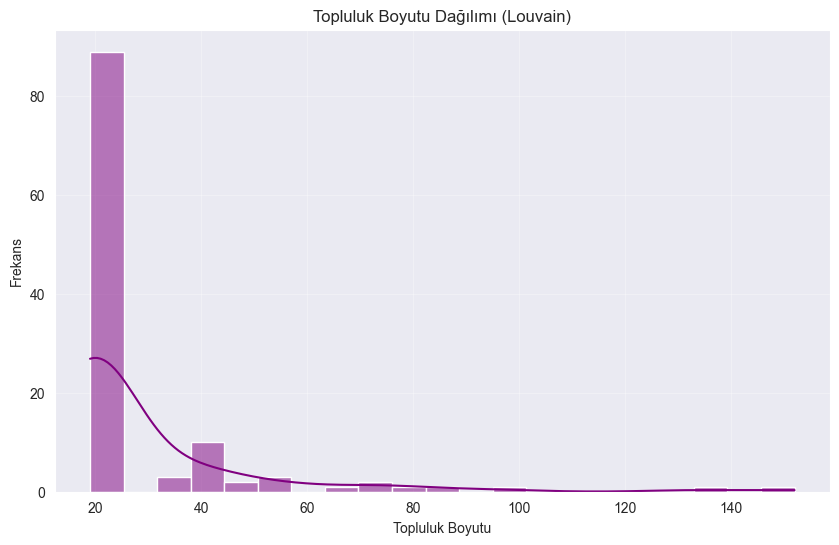

In [16]:
G_community_undirected = G.to_undirected()

print(f"Alt graf düğüm sayısı: {G_community_undirected.number_of_nodes()}")
print(f"Alt graf kenar sayısı: {G_community_undirected.number_of_edges()}")

start_time_louvain = time.time()
detected_communities_louvain = community.louvain_communities(G_community_undirected, seed=42)
end_time_louvain = time.time()

communities_as_list = list(detected_communities_louvain)

print(f"Tespit edilen topluluk sayısı: {len(communities_as_list)}")

if communities_as_list:
    community_sizes_list = [len(c) for c in communities_as_list]
    print(f"En büyük topluluk boyutu: {max(community_sizes_list)}")
    print(f"En küçük topluluk boyutu: {min(community_sizes_list)}")
    print(f"Ortalama topluluk boyutu: {np.mean(community_sizes_list):.2f}")
    print(f"Louvain hesaplama süresi: {end_time_louvain - start_time_louvain:.2f} saniye")

    calculated_modularity = community.modularity(G_community_undirected, communities_as_list)
    print(f"Modülerlik puanı: {calculated_modularity:.4f}")

    plt.figure(figsize=(10, 6))
    sns.histplot(community_sizes_list, kde=True, color='purple', bins=min(30, len(set(community_sizes_list))))
    plt.title("Topluluk Boyutu Dağılımı (Louvain)")
    plt.xlabel("Topluluk Boyutu")
    plt.ylabel("Frekans")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Louvain algoritması ile topluluk tespit edilemedi veya alt graf boş.")


In [20]:
net = Network(notebook=True, cdn_resources='in_line', directed=False)

# Topluluk renklerini hazırla
num_communities = len(detected_communities_louvain)
colors = cm.get_cmap('viridis', num_communities)

degrees = dict(G_community_undirected.degree())
node_sizes = {node: max(20, min(150, 5 * np.sqrt(deg))) for node, deg in degrees.items()}

# Düğümleri ve kenarları ekle
for i, community_nodes in enumerate(detected_communities_louvain):
    color_hex = "#{:02x}{:02x}{:02x}".format(
        int(colors(i)[0]*255),
        int(colors(i)[1]*255),
        int(colors(i)[2]*255)
    )

    for node in community_nodes:
        net.add_node(
            node,
            label=str(node) if node in sorted(degrees, key=degrees.get, reverse=True)[:30] else "",
            title=f"Node: {node}<br>Degree: {degrees[node]}<br>Community: {i}",
            color=color_hex,
            size=node_sizes[node]
        )

# Kenarları ekle
for u, v in G_community_undirected.edges():
    net.add_edge(u, v, color="gray", width=0.2)

net.toggle_physics(False)

net.set_options("""
var options = {
  "physics": {
    "enabled": true,
    "solver": "forceAtlas2Based",
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "springLength": 100,
      "springConstant": 0.08
    },
    "minVelocity": 0.75,
    "stabilization": {
      "enabled": true,
      "iterations": 1000
    }
  },
  "nodes": {
    "borderWidth": 1,
    "shape": "dot"
  },
  "edges": {
    "smooth": true,
    "color": {
      "inherit": false
    }
  }
}
""")

print(f"{num_communities} topluluk")
net.show("web_google_communities_interactive.html")

/var/folders/4z/5gxbzx257gx3svm8v6hzvnlh0000gn/T/ipykernel_32236/221623422.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', num_communities)


KeyboardInterrupt: 

## Özet ve Sonuçlar

Web-Google ağı, Google'ın web sayfalarını temsil eden bir ağdır. Bu analiz, ağın yapısal özelliklerini ve karakteristiklerini ortaya çıkarmıştır.

Analizimizin başlıca bulguları:
1. Ağ büyük ölçekli ve karmaşık bir yapıya sahiptir.
2. Derece dağılımı, güç yasası özelliği göstermektedir, bu da bazı web sayfalarının çok sayıda bağlantıya sahip olduğunu, çoğunun ise göreceli olarak az bağlantıya sahip olduğunu gösterir.
3. Ağın düşük yoğunluğa sahip olması, web sayfaları arasındaki bağlantıların seyrektir.
4. Kümelenme katsayısı, web sayfalarının tematik olarak gruplanma eğilimini gösterir.
5. Topluluk tespiti, benzer içeriğe sahip web sayfalarının kümelerini tanımlar.
6. K-core analizi, ağın hiyerarşik yapısını ve bağlantı desenlerini gösterir.

Bu bulgular, web ağlarının doğası hakkında değerli bilgiler sağlar ve SEO, sosyal medya analizi ve web sayfası optimizasyonu gibi çeşitli alanlarda kullanılabilir.


## Gephi İçin Veri Dışa Aktarma

Bu bölümde, ağ verilerini Gephi'de detaylı analiz için dışa aktarıyoruz. Veriyi GEXF (Graph Exchange XML Format) formatında dışa aktarıyoruz, bu Gephi'nin tercih ettiği bir formattır.


In [102]:
try:
    nx.write_gexf(G, "web_google_full.gexf")
    print(f"Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf")
except Exception as e:
    print(f"Gephi için veri dışa aktarma sırasında hata oluştu: {e}")
print("Analiz ve dışa aktarma işlemleri tamamlandı.")

Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf
Analiz ve dışa aktarma işlemleri tamamlandı.
